lesson01_170017231_LGjs_Luis-Guilherme-Simoes

# Atividade semana 1: É um pássaro? É um avião?
> Luís Guilherme Julião Simões — 17/0017231

A atividade dessa semana consiste em treinar uma rede neural para diferenciar duas categorias pré-determinadas de imagens.
A rede em questão já é pré treinada, então é necessário apenas fornecer imagens das categorias desejadas e rodar algumas iterações de *tuning*.
Depois ela será testada com outras imagens para validação.

As categorias escolhidas foram de aviões e pássaros.
Os passos para realizar o treinamento são simples:
1. usar DuckDuckGo para buscar imagens de aviões,
2. usar DuckDuckGo para buscar imagens de pássaros,
3. refinar um modelo pré-treinado de rede neural para diferenciar entre as duas categorias,
4. testar o modelo em uma imagem diferente.

## *Check-up*, importações e definições

In [1]:
# check-up de conexão com internet
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# check-up de instalações
if iskaggle:
    %pip install -Uqq fastai

%pip install -Uqq duckduckgo_search


Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports and defs
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep


def search_images(term, max_images=200): # função para buscar imagens usando a duckduckgo
    return L(ddg_images(term, max_results=max_images)).itemgot('image')


### Teste da função definida
A função definida é testada aqui, já aproveitando para salvar uma imagem de cada categoria para testes futuros da rede.

In [11]:
# teste da função
urls = search_images('aviao', max_images=1)
dest = 'aviao.jpg'
download_url(urls[0], dest, show_progress=False)
# im = Image.open(dest)
# im.to_thumb(256,256)

download_url(search_images('passaro', max_images=1)[0], 'passaro.jpg', show_progress=False)
# Image.open('passaro.jpg').to_thumb(256,256)

Path('passaro.jpg')

## Definição das categorias
Aqui são definidas as categorias de busca para o aprendizado.
Também é feito o *download* 

In [12]:
searches = 'aviao','passaro'
path = Path('e_um_passaro_e_um_aviao')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

## Treinamento
Antes de iniciar, deve-se retirar alguns possíveis erros ocorridos no *download* de algumas imagens.

In [13]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

Para fazer o treinamento, é preciso criar *DataLoaders* (objetos que contêm agrupamentos de imagens para teste e para validação).
Utilizando a função `DataBlock`, podemos criar esses agrupamentos com, no caso, 20% de imagens para validação, escolhidas aleatoriamente do conjunto de imagens salvas.

d:\Programas\Python311\Lib\site-packages\fastai\data\transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


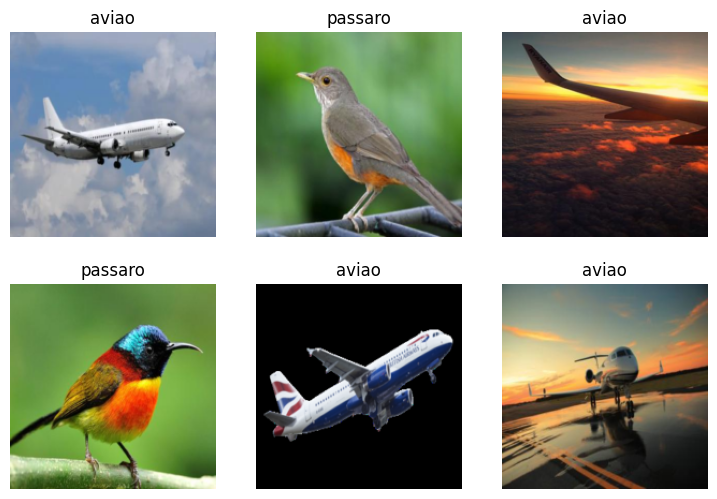

In [14]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

### O aprendizado
Foi escolhido o modelo `resnet18`, muito utilizado para análise de imagens.
Também foi escolhida a métrica de avaliação como sendo as taxas de erro.
E por fim, foram feitas três iterações de refinamento.

In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

d:\Programas\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Programas\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.725964,0.419519,0.110000,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.158782,0.245454,0.110000,00:53
1,0.103531,0.246233,0.110000,00:51
2,0.073300,0.155810,0.080000,00:53


## Teste do modelo

In [17]:
e_um_aviao,_,probs = learn.predict(PILImage.create('aviao.jpg'))
print(f"Isso é um: {e_um_aviao}.")
print(f"Probabilidade de ser um aviao: {probs[0]:.4f}")

Isso é um: aviao.
Probabilidade de ser um aviao: 1.0000
